# Импорт библиотек

In [ ]:
from collections import Counter
from datetime import datetime
from itertools import chain
from nltk.sentiment import SentimentIntensityAnalyzer
from re import split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import gdown
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as sklm
import sklearn.metrics as skmtr
import sklearn.model_selection as skms
import sklearn.preprocessing as sklp

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Загрузка и обработка данных

## Загрузка датасетов

Скачаем датасеты с Google Drive.

In [ ]:
file_id = "1_sYqRu_in8ZBzh7LcnJl1yK7cGVNzDpa"
url = f"https://drive.google.com/uc?id={file_id}"
output = "metacritic_games.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1_sYqRu_in8ZBzh7LcnJl1yK7cGVNzDpa
To: /content/metacritic_games.csv
100%|██████████| 14.4M/14.4M [00:00<00:00, 35.2MB/s]


'metacritic_games.csv'

In [ ]:
file_id = "1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW"
url = f"https://drive.google.com/uc?id={file_id}"
output = "metacritic_reviews.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW
From (redirected): https://drive.google.com/uc?id=1Fa9i118HY2GMswSKENrv6SCZpWnsnTqW&confirm=t&uuid=54440c65-b607-4266-ab64-d648015a3bbb
To: /content/metacritic_reviews.csv
100%|██████████| 280M/280M [00:03<00:00, 73.1MB/s]


'metacritic_reviews.csv'

## Обработка основного датасета

Для начала обработаем основной датасет. Уберём ненужные столбцы и удалим строки с пропусками данных. Затем переведём значения userscore в целочисленный диапазон от 0 до 100 и переформируем колонку release date в year типа int.

In [ ]:
metacritic_games = pd.read_csv('metacritic_games.csv', sep=',')

cols_to_drop = ['esrb_rating', 'ESRBs', 'num_players', 'user_reviews', 'critic_reviews', 'summary', 'metascore']
metacritic_games = metacritic_games.drop(columns=cols_to_drop)
new_columns = ['id', 'title', 'year', 'genre', 'platform', 'developer', 'userscore']
metacritic_games.columns = new_columns
metacritic_games = metacritic_games.drop(columns='id')

metacritic_games['year'] = pd.to_datetime(metacritic_games['year'], format="%b %d, %Y", errors='coerce')
metacritic_games['userscore'] = metacritic_games['userscore'].replace('tbd', None)

metacritic_games['genre'] = metacritic_games['genre'].replace(' ', None)

metacritic_games = metacritic_games.dropna()

metacritic_games['userscore'] = metacritic_games['userscore'].astype(float)
metacritic_games['year'] = metacritic_games['year'].apply(lambda x: x.year).astype(int)

metacritic_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17929 entries, 0 to 19316
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      17929 non-null  object 
 1   year       17929 non-null  int64  
 2   genre      17929 non-null  object 
 3   platform   17929 non-null  object 
 4   developer  17929 non-null  object 
 5   userscore  17929 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 980.5+ KB


<ipython-input-64-89f7a4e01de2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metacritic_games['userscore'] = metacritic_games['userscore'].astype(float)
<ipython-input-64-89f7a4e01de2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metacritic_games['year'] = metacritic_games['year'].apply(lambda x: x.year).astype(int)


### Обработка категориальных признаков

Выведем количества уникальных значений для категориальных признаков:

In [ ]:
print(f"Unique developer count: {len(metacritic_games['developer'].unique())}")
print(f"Unique platform count: {len(metacritic_games['platform'].unique())}")
print(f"Unique genres combination count: {len(metacritic_games['genre'].unique())}")
print(f"Unique year count: {len(metacritic_games['year'].unique())}")

Unique developer count: 4376
Unique platform count: 22
Unique genres combination count: 2151
Unique year count: 28


Из соображений безопасности создадим рабочую копию датасета:

In [ ]:
prediction_df = metacritic_games.copy()

Для столбца platform  подойдет One-Hot Encoder, так как уникальных значений платформ всего 22, то есть мы не очень сильно увеличим размерность данных.

Аналогично с годом выпуска игр

In [ ]:
prediction_df = pd.get_dummies(prediction_df, columns=['platform'], drop_first=True)
prediction_df = pd.get_dummies(prediction_df, columns=['year'], drop_first=True)

Посмотрим на распределение количества выпущенных разработчиками игр:

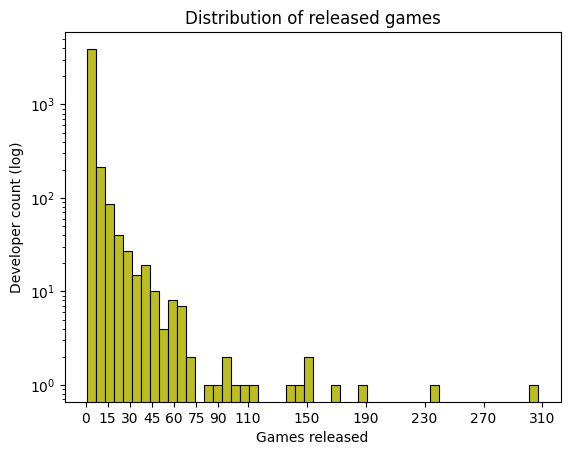

In [ ]:
df_counts = prediction_df['developer'].value_counts().reset_index()
plt.hist(df_counts['count'], bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
plt.xticks(list(np.arange(0, 100, 15)) + list(np.arange(110, 350, 40)))
plt.yscale('log')
plt.xlabel("Games released")
plt.ylabel("Developer count (log)")
plt.title("Distribution of released games")
plt.show()

Сделаем следующее: выделим несколько групп студий по количеству выпущенных игр и запишем для них в столбец developer название группы.

In [ ]:
prediction_df['count'] = prediction_df['developer'].map(prediction_df['developer'].value_counts())
prediction_df.loc[prediction_df['count'] <= 75, 'developer'] = 'other0'
prediction_df.loc[prediction_df['count'] <= 50, 'developer'] = 'other1'
prediction_df.loc[prediction_df['count'] <= 40, 'developer'] = 'other2'
prediction_df.loc[prediction_df['count'] <= 30, 'developer'] = 'other3'
prediction_df.loc[prediction_df['count'] <= 20, 'developer'] = 'other4'
prediction_df.loc[prediction_df['count'] <= 15, 'developer'] = 'other5'
prediction_df.loc[prediction_df['count'] <= 10, 'developer'] = 'other6'
prediction_df.loc[prediction_df['count'] <= 5, 'developer'] = 'other7'
prediction_df.loc[prediction_df['count'] <= 3, 'developer'] = 'other8'
prediction_df.loc[prediction_df['count'] <= 2, 'developer'] = 'other9'
prediction_df.loc[prediction_df['count'] <= 1, 'developer'] = 'other10'
prediction_df = prediction_df.drop(columns='count')

print(f"Unique developer count: {len(prediction_df['developer'].unique())}")

Unique developer count: 26


Теперь у нас всего 26 уникальных значений в столбце developer, 15 из которых отвечают за самые крупные студии, тогда как 11 соответствуют выделенным группам разработчиков.

In [ ]:
prediction_df = pd.get_dummies(prediction_df, columns=['developer'], drop_first=True)

Подготовим столбец genre. Каждой игре соответствует несколько жанров, поэтому необходимо обработать данные. Убедимся, что названия жанров в ячейках не повторяются и не содержат лишних символов. Затем объединим их в строки с разделителем, чтобы применить аналог OHE.

In [ ]:
prediction_df['genre'] = prediction_df['genre'].apply(lambda x: list(set(split(r'[ ,]{2,}', x))))
prediction_df['genre'] = prediction_df['genre'].apply(lambda x: list(map(lambda x: x.strip(','), x)))
prediction_df['genre'] = prediction_df['genre'].apply(lambda x: '|'.join(x))
genre_OHE_df = prediction_df['genre'].str.get_dummies(sep='|')
genre_OHE_df.head(5)

,2D,3D,4X,Action,Action Adventure,Action RPG,Adventure,Alternative,Application,Arcade,...,Virtual,Virtual Life,Visual Novel,Volleyball,WWI,WWII,Wakeboarding,Wargame,Western-Style,Wrestling
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Добавим полученные столбцы в датасет и выведем его:

In [ ]:
prediction_df = prediction_df.join(genre_OHE_df)

prediction_df.head(10)

,title,genre,userscore,platform_DS,platform_Dreamcast,platform_Game Boy Advance,platform_GameCube,platform_Nintendo 64,platform_PC,platform_PSP,...,Virtual,Virtual Life,Visual Novel,Volleyball,WWI,WWII,Wakeboarding,Wargame,Western-Style,Wrestling
0,Burnout 3: Takedown,Arcade|Driving|Racing,7.7,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,Jet Grind Radio,Platformer|3D|Action,8.3,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,Metal Gear Solid 4: Guns of the Patriots,Modern|Action Adventure|General,8.8,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,Tom Clancy's Splinter Cell Chaos Theory,Modern|Action Adventure,9.1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,Call of Duty: Modern Warfare 2,Action|Shooter|First-Person|Modern|Arcade,6.6,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
5,NCAA Football 2004,Traditional|Sports|Football|Sim,8.3,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6,Metal Gear Solid 3: Subsistence,Modern|Action Adventure,9.1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
7,Diablo,Action RPG|Role-Playing,8.6,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
8,Madden NFL 2004,Traditional|Sports|Football|Sim,7.0,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
9,Virtua Fighter 4,Fighting|3D|Action,8.1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


## Обработка датасета с отзывами

Обработаем датасет с отзывами.

Для начала заметим, что в датасете каждому отзыву сопоставлен рейтинг, поставленный пользователем. Мы не будем использовать его. Вместо этого для каждого отзыва мы проведем анализ тональности с использованием NLTK, усреднив полученное число по каждой игре. Тогда столбец с тональностью отзывов будет интерпретируем как общее эмоциональное впечатление игроков об игре, которое любой желающий купить игру может понять, также прочитав отзывы.

In [ ]:
metacritic_reviews = pd.read_csv('metacritic_reviews.csv', sep=',')

metacritic_reviews = metacritic_reviews.drop(metacritic_reviews.columns[[0, 1, 3]], axis=1)

metacritic_reviews.columns = ['title', 'review']

metacritic_reviews['review'] = metacritic_reviews['review'].replace(np.nan, None)
metacritic_reviews = metacritic_reviews.dropna()

metacritic_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416386 entries, 0 to 416618
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   416386 non-null  object
 1   review  416386 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB


In [ ]:
# Выполняется ~10 минут

sia = SentimentIntensityAnalyzer()

metacritic_reviews['review_mood'] = metacritic_reviews['review'].apply(lambda x: sia.polarity_scores(x)['compound']).astype(float)

metacritic_reviews.head(10)

,title,review,review_mood
0,Rockstar Games presents Table Tennis,Amazingly Addicting!,0.0000
1,Disney's Magical Mirror Starring Mickey Mouse,this game lets you able to play as mickey mou...,0.9078
2,Deus Ex: Invisible War,Yet another disappointment to add to 2003's r...,-0.9302
3,Mobile Suit Gundam: Journey to Jaburo,I love this Game!,0.6696
4,Dead to Rights: Reckoning,This is a really good game for people ...,0.7501
5,NHL 2K3,This is the best hockey game i have ever play...,0.9565
6,Killing Floor,"This is a very fun zombie shooter, left 4 dead...",-0.9449
7,Call for Heroes: Pompolic Wars,Lets pretend that 'Nathan C.' isn't affiliate...,0.1655
8,TimeSplitters 2,One of the Best Games Ever... Time you are wa...,0.8316
9,Starship Troopers: Terran Ascendancy,WE NEED MULTIPLAYER GAME FOR STARSHIP TROOPER...,0.0000


Объединим и усредним данные по каждой игре.

In [ ]:
mood_df = metacritic_reviews.groupby("title", as_index=False)["review_mood"].mean()

mood_df.head(10)

,title,review_mood
0,#DRIVE,0.760167
1,#IDARB,0.856427
2,#KILLALLZOMBIES,0.671300
3,'Splosion Man,0.751594
4,.detuned,-0.056687
5,.hack//G.U. Last Recode,0.673904
6,.hack//G.U. vol. 1//Rebirth,0.708229
7,.hack//G.U. vol. 2//Reminisce,0.893400
8,.hack//G.U. vol. 3//Redemption,0.991650
9,.hack//Infection Part 1,0.491731


Формируем датасет для предсказаний с отзывами:

In [ ]:
prediction_df_2 = pd.merge(prediction_df, mood_df, on="title", how="inner")

prediction_df_2.head(10)

,title,genre,userscore,platform_DS,platform_Dreamcast,platform_Game Boy Advance,platform_GameCube,platform_Nintendo 64,platform_PC,platform_PSP,...,Virtual Life,Visual Novel,Volleyball,WWI,WWII,Wakeboarding,Wargame,Western-Style,Wrestling,review_mood
0,Burnout 3: Takedown,Arcade|Driving|Racing,7.7,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0.487457
1,Jet Grind Radio,Platformer|3D|Action,8.3,False,True,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0.737282
2,Metal Gear Solid 4: Guns of the Patriots,Modern|Action Adventure|General,8.8,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0.702854
3,Tom Clancy's Splinter Cell Chaos Theory,Modern|Action Adventure,9.1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0.558606
4,Call of Duty: Modern Warfare 2,Action|Shooter|First-Person|Modern|Arcade,6.6,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0.214417
5,NCAA Football 2004,Traditional|Sports|Football|Sim,8.3,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0.608272
6,Metal Gear Solid 3: Subsistence,Modern|Action Adventure,9.1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0.599377
7,Diablo,Action RPG|Role-Playing,8.6,False,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0.466314
8,Madden NFL 2004,Traditional|Sports|Football|Sim,7.0,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0.490527
9,Virtua Fighter 4,Fighting|3D|Action,8.1,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0.421970


# Предсказания без отзывов

## Разбиение данных на выборки

Сделаем копию датасета prediction_df и выделим матрицу признаков и столбец таргетов. Пока что отделим от датасета строчки с уникальным значением таргета.

In [ ]:
X = prediction_df.copy()

X = X.drop(columns=['title', 'genre'])

unique = X[X['userscore'].map(X['userscore'].value_counts()) == 1]
X = X[~X.index.isin(unique.index)]

unique = unique.reset_index(drop = True)
X = X.reset_index(drop = True)

y = X['userscore'] # target column
X = X.drop(columns='userscore') # feature matrix

Разделим датасет на обучающую и тестовую выборки. Используем параметр stratify, чтобы распределение данных в обучающей и тестовой выборках были одинаковыми. Добавим к обучающей выборке отделенные ранее строчки:

In [ ]:
X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

X_train = pd.concat([X_train, unique.drop(columns='userscore')])
y_train = pd.concat([y_train, unique['userscore']])
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

Проведем стандартизацию данных: удалим среднее и масштабируем дисперсию к единице.


In [ ]:
scaler = sklp.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Линейная регрессия

Обучим линейную модель и посчитаем RMSE и MAPE на обучающей и тестовой выборках:

In [ ]:
model = sklm.LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

Errors on test data:
MAPE: 0.176885
RMSE: 1.259128
Errors on train data:
MAPE: 0.176014
RMSE: 1.238280


Видим довольно высокую ошибку. Изобразим диаграмму сравнения реальных таргетов и предсказанных. Чем ближе точка к красной линии, тем точнее было предсказание модели:

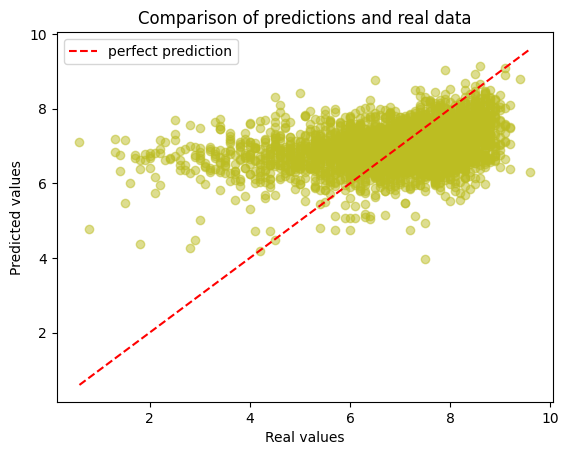

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Модель плохо обучилась: чаще всего она предсказывает значения в интервале $[60, 80]$. Проверим распределения таргетов:

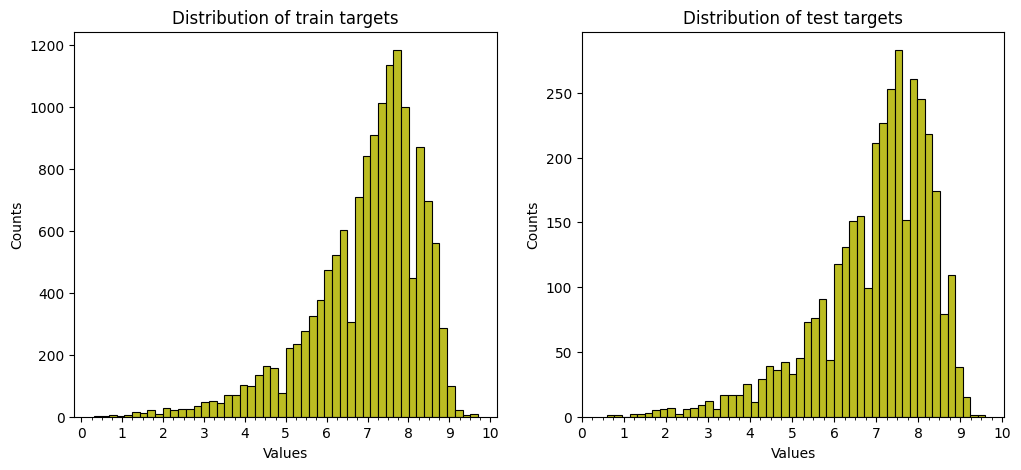

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(y_train, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
ax[0].set_title("Distribution of train targets")
ax[0].set_xticks(np.arange(0, 10.25, 0.25), minor=True)
ax[0].set_xticks(np.arange(0, 11, 1))
ax[0].set_xticklabels(np.arange(0, 11, 1))
ax[0].set_xlabel("Values")
ax[0].set_ylabel('Counts')

ax[1].hist(y_test, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
ax[1].set_title("Distribution of test targets")
ax[1].set_xticks(np.arange(0, 10.25, 0.25), minor=True)
ax[1].set_xticks(np.arange(0, 11, 1))
ax[1].set_xticklabels(np.arange(0, 11, 1))
ax[1].set_xlabel("Values")
ax[1].set_ylabel('Counts')

plt.show()

В данных имеется существенный перекос, то есть большинство игр имеют рейтинг в диапазоне от 60 до 80. Из-за этого обученная модель имеет плохую обобщающую способность.

Можно попробовать обучить модель на части датасета, удалив лишние значения из диапазона $[6.25, 9.75]$.

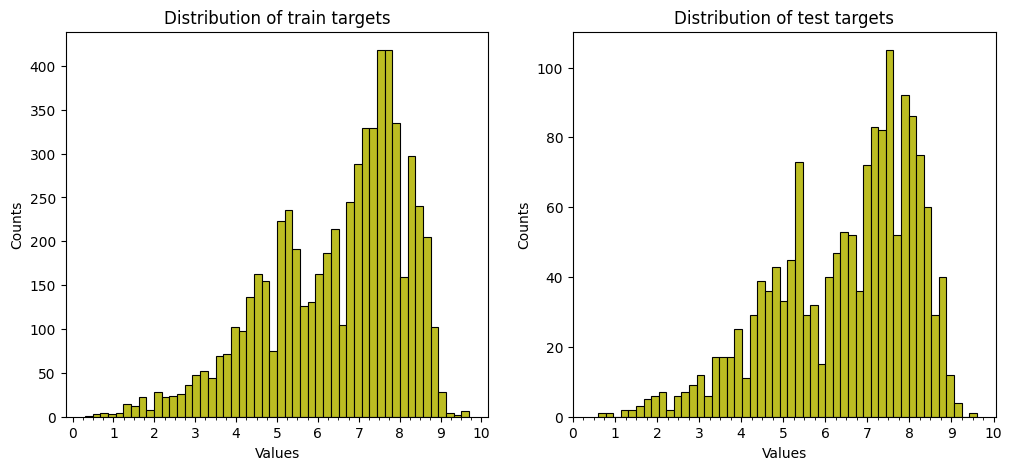

In [ ]:
X_filt = prediction_df.copy()

in_range = prediction_df[(prediction_df['userscore'] >= 5.5) & (prediction_df['userscore'] <= 9.75)]
to_drop = in_range.sample(frac=0.65, random_state=42)
X_filt = X_filt.drop(to_drop.index)

X_filt = X_filt.drop(columns=['title', 'genre'])

unique = X_filt[X_filt['userscore'].map(X_filt['userscore'].value_counts()) == 1]
X_filt = X_filt[~X_filt.index.isin(unique.index)]

unique = unique.reset_index(drop = True)
X_filt = X_filt.reset_index(drop = True)

y_filt = X_filt['userscore']
X_filt = X_filt.drop(columns='userscore')

X_train2, X_test2, y_train2, y_test2 = skms.train_test_split(X_filt, y_filt, test_size=0.2, random_state=2, stratify=y_filt)

X_train2 = pd.concat([X_train2, unique.drop(columns='userscore')])
y_train2 = pd.concat([y_train2, unique['userscore']])
X_train2 = X_train2.reset_index(drop = True)
y_train2 = y_train2.reset_index(drop = True)

scaler = sklp.StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(y_train2, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
ax[0].set_title("Distribution of train targets")
ax[0].set_xticks(np.arange(0, 10.25, 0.25), minor=True)
ax[0].set_xticks(np.arange(0, 11, 1))
ax[0].set_xticklabels(np.arange(0, 11, 1))
ax[0].set_xlabel("Values")
ax[0].set_ylabel('Counts')

ax[1].hist(y_test2, bins=50, color='tab:olive', linewidth=0.8, edgecolor='black')
ax[1].set_title("Distribution of test targets")
ax[1].set_xticks(np.arange(0, 10.25, 0.25), minor=True)
ax[1].set_xticks(np.arange(0, 11, 1))
ax[1].set_xticklabels(np.arange(0, 11, 1))
ax[1].set_xlabel("Values")
ax[1].set_ylabel('Counts')

plt.show()

In [ ]:
model = sklm.LinearRegression()
model.fit(X_train2, y_train2)

y_pred = model.predict(X_test2)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test2, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test2, y_pred))
print(f"RMSE: {rmse_test:.6f}")

y_pred_train = model.predict(X_train2)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train2, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train2, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

Errors on test data:
MAPE: 0.258794
RMSE: 1.561124
Errors on train data:
MAPE: 0.256018
RMSE: 1.509398


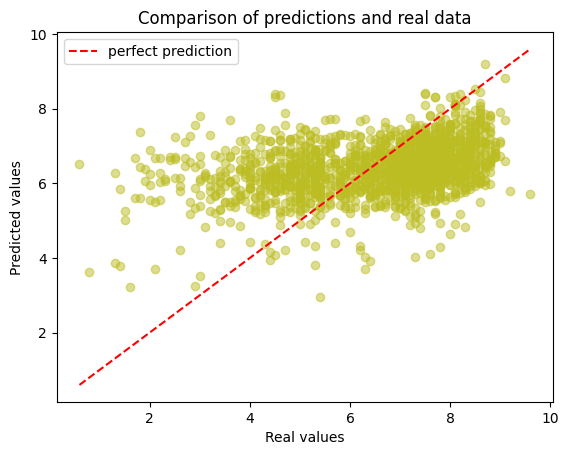

In [ ]:
plt.scatter(y_test2, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test2), max(y_test2)], [min(y_test2), max(y_test2)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Предсказание стало только хуже. Отсюда можно сделать вывод, что улучшение распределения путем уменьшения количества данных в датасете не помогает.

## Решающее дерево

Попробуем нелинейные модели, которые способны выявить более сложные зависимости в данных. Попробуем метод дерева решений. Подберем наилучшую глубину дерева через GridSearchCV, а затем обучим модель.

In [ ]:
max_depth_values = {'max_depth': np.arange(1, 15, 1)}

search = GridSearchCV(DecisionTreeRegressor(),
                     max_depth_values,
                     scoring='neg_root_mean_squared_error',
                     cv=10)

print('Лучшее значение max_depth:', search.fit(X_train, y_train).best_params_)

Лучшее значение max_depth: {'max_depth': np.int64(7)}


In [ ]:
tree_regressor = DecisionTreeRegressor(max_depth=7)
tree_regressor.fit(X_train, y_train)

y_pred = tree_regressor.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

Errors on test data:
MAPE: 0.184036
RMSE: 1.304909
Errors on train data:
MAPE: 0.188192
RMSE: 1.371625


Строим аналогичную диаграмму:

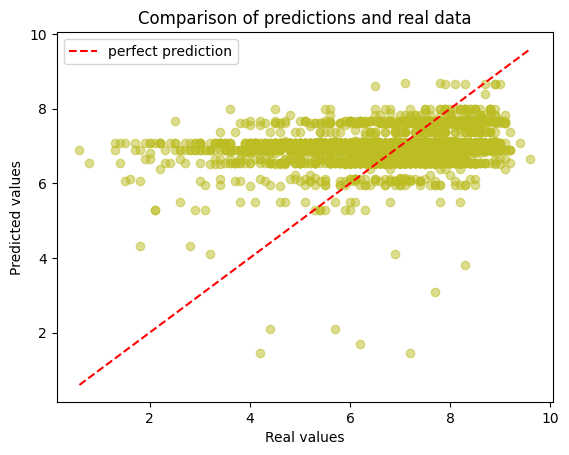

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Видим, что на этих данных дерево обучилось даже хуже линейной модели.

## Градиентный бустинг

Попробуем использовать модель градиентного бустинга. Благодаря итерационности процесса, градиентный бустинг должен улучшить результат одного дерева. Значения гиперпараметров были подобраны локально ввиду ограниченных вычислительных скоростей Google Colab.

In [ ]:
gb_regr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.025, max_depth=11, max_features='log2', random_state=42)

gb_regr.fit(X_train, y_train)

y_pred = gb_regr.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

Errors on test data:
MAPE: 0.166943
RMSE: 1.208704
Errors on train data:
MAPE: 0.188192
RMSE: 1.371625


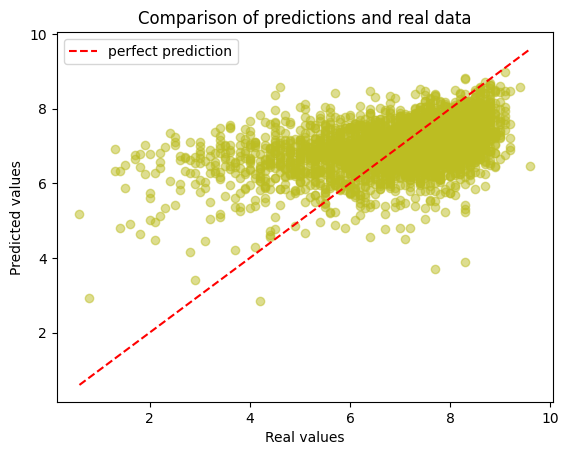

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Качество предсказаний модели улучшилось, но основная проблема осталась той же. Можно сделать вывод, что так как все используемые признаки категориальны, зависимости довольно условны, что не позволяет нам обучить модель правильно. Кроме того, не очень хорошее распределение данных также сказывается на качестве предсказания.

Теперь имеет смысл добавить к признакам отзывы об игре и проверить, улучшит ли это предсказания моделей.

# Предсказания с отзывами

Датасет с отзывами уже обработан. Используем его для обучения тех же моделей.

## Разбиение данных на выборки

In [ ]:
X = prediction_df_2.copy()

X = X.drop(columns=['title', 'genre'])

unique = X[X['userscore'].map(X['userscore'].value_counts()) == 1]
X = X[~X.index.isin(unique.index)]

unique = unique.reset_index(drop = True)
X = X.reset_index(drop = True)

y = X['userscore'] # target column
X = X.drop(columns='userscore') # feature matrix

X_train, X_test, y_train, y_test = skms.train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

X_train = pd.concat([X_train, unique.drop(columns='userscore')])
y_train = pd.concat([y_train, unique['userscore']])
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

scaler = sklp.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Линейная регрессия

In [ ]:
model = sklm.LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

Errors on test data:
MAPE: 0.157747
RMSE: 1.143601
Errors on train data:
MAPE: 0.158594
RMSE: 1.136552


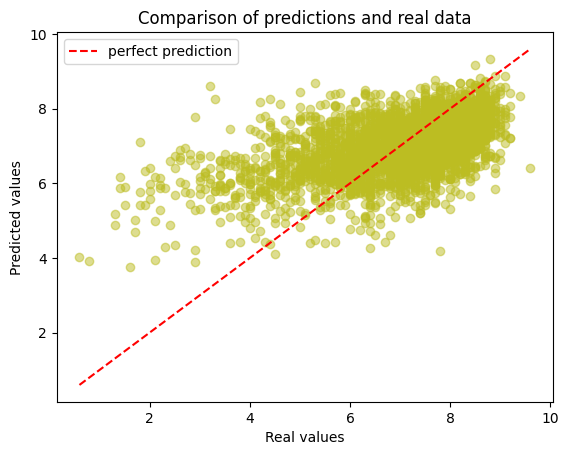

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Видим, что столбец с тональностью отзывов уменьшил MAPE и RMSE линейной модели. Проверим результаты на остальных типах моделей.

## Решающие деревья и градиентный бустинг

In [ ]:
tree_regressor = DecisionTreeRegressor(max_depth=8)
tree_regressor.fit(X_train, y_train)

y_pred = tree_regressor.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

Errors on test data:
MAPE: 0.156188
RMSE: 1.159259
Errors on train data:
MAPE: 0.158594
RMSE: 1.136552


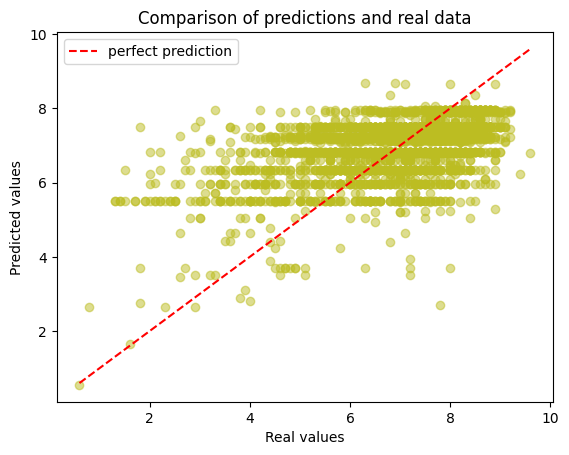

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Теперь обучим градиентный бустинг с теми же параметрами. Посчитаем дополнительно R2-score.

In [ ]:
gb_regr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.025, max_depth=11, max_features='log2', random_state=42)

gb_regr.fit(X_train, y_train)

y_pred = gb_regr.predict(X_test)

print('Errors on test data:')

mape_test = skmtr.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape_test:.6f}")

rmse_test = np.sqrt(skmtr.mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse_test:.6f}")

r2_test = skmtr.r2_score(y_test, y_pred)
print(f"R2-score: {r2_test:.6f}")

y_pred_train = model.predict(X_train)

print('Errors on train data:')

mape_train = skmtr.mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE: {mape_train:.6f}")

rmse_train = np.sqrt(skmtr.mean_squared_error(y_train, y_pred_train))
print(f"RMSE: {rmse_train:.6f}")

r2_train = skmtr.r2_score(y_train, y_pred_train)
print(f"R2-score: {r2_train:.6f}")

Errors on test data:
MAPE: 0.142771
RMSE: 1.061910
R2-score: 0.378202
Errors on train data:
MAPE: 0.158594
RMSE: 1.136552
R2-score: 0.293696


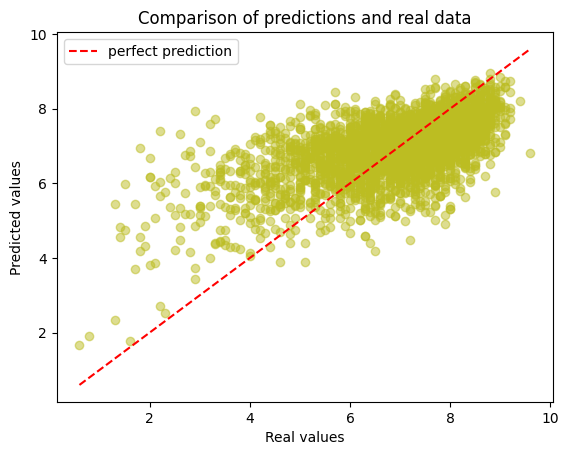

In [ ]:
plt.scatter(y_test, y_pred, alpha=0.5, color='tab:olive')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='perfect prediction')
plt.legend()
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.title("Comparison of predictions and real data")
plt.show()

Теперь RMSE составляет $1.06$, что позволяет нам сказать, что квадрат разницы истинного значения и предсказания модели примерно равен $1.12$. Также MAPE показывает, что мы ошибаемся в среднем на 14%. Из R2 можно заключить, что предсказательные способности модели ниже средних. Очевидно, что столбец признаков улучшил качество модели. Для полной уверенности посмотрим на самые важные признаки:

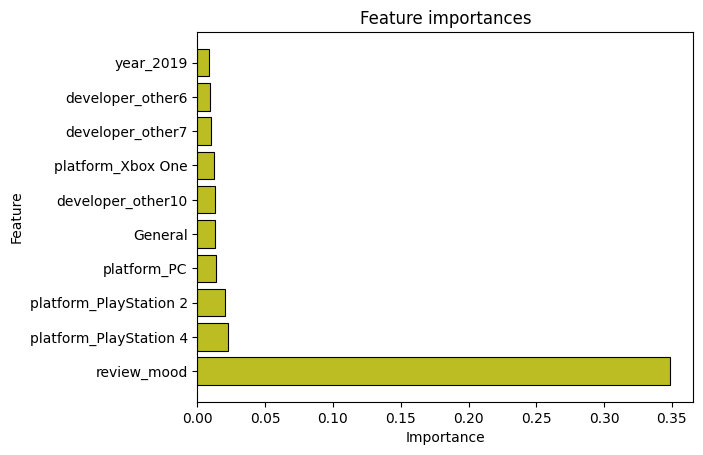

In [ ]:
feature_importances = gb_regr.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

plt.barh(feature_importance_df["Feature"].head(10), feature_importance_df["Importance"].head(10), color='tab:olive', linewidth=0.8, edgecolor='black')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature importances")
plt.show()

# Итог

Мы добились приемлемого качества предсказаний модели. Основными проблемами стали:

*   **Плохое распределение данных** - чаще всего в столбце рейтинга встречаются значения из диапазона от 6 до 8, что в целом соответствует реальности. Из-за этого модели плохо обобщают предсказания на весь возможный диапазон.
*   **Отсутствие числовых признаков** - все данные основного датасета были категориальными. В открытом доступе не было найдено датасета, содержащего дополнительные признаки (к примеру, цену игры). Это объясняется в том числе сложностью изучаемого объекта: видеоигры выпускаются на разных платформах разными разработчиками, из-за чего сбор комплексных данных зачастую затруднен.

Использование тональности отзывов об игре не является совершенно честным с точки зрения предсказания, так как основной целью работы было предсказать рейтинг игры до её выхода. На данном этапе определенно можно сказать, что видеоигры, как и другие виды искусства, не являются объектом, чьи свойства можно предсказать с высокой точностью. Можно продолжить исследование, работая в следующих направлениях:

*   Ручной парсинг комплексных данных с разных платформ и последующий feature engineering.
*   Использование более продвинутых методов предсказания, вплоть до глубинного обучения.



